# ML match for LOFAR and the combined PanSTARRS WISE catalogue: Gaussians catalogue

## Configuration

### Load libraries and setup

In [1]:
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
import pickle

In [2]:
from mltier1 import (get_center, get_n_m, estimate_q_m, Field, SingleMLEstimator, MultiMLEstimator,
                     parallel_process, get_sigma, get_q_m)

In [3]:
%load_ext autoreload

In [4]:
%autoreload

In [5]:
from IPython.display import clear_output

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### General configuration

In [7]:
save_intermediate = True
plot_intermediate = True

In [ ]:
idp = "idata/gaus"

In [ ]:
if not os.path.isdir(idp):
    os.makedirs(idp)

### Area limits

In [8]:
ra_down0 = 170.0
ra_up0 = 190.0
dec_down0 = 45.5
dec_up0 = 56.5

In [9]:
# Busy week Edinburgh 2017
ra_down = 172.09
ra_up = 187.5833
dec_down = 46.106
dec_up = 56.1611

In [10]:
# Busy week Hatfield 2017
ra_down = 170.
ra_up = 190.
dec_down = 46.8
dec_up = 55.9

In [11]:
field = Field(170.0, 190.0, 46.8, 55.9)

## Load data

In [12]:
combined = Table.read("pw.fits")

In [13]:
lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_catalog_v0.1.gaus.fits")

In [14]:
np.array(combined.colnames)

array(['AllWISE', 'objID', 'ra', 'dec', 'raErr', 'decErr', 'W1mag',
       'W1magErr', 'i', 'iErr'], 
      dtype='<U8')

In [15]:
np.array(lofar_all.colnames)

array(['Source_Name', 'RA', 'E_RA', 'E_RA_tot', 'DEC', 'E_DEC',
       'E_DEC_tot', 'Peak_flux', 'E_Peak_flux', 'E_Peak_flux_tot',
       'Total_flux', 'E_Total_flux', 'E_Total_flux_tot', 'Maj', 'E_Maj',
       'Min', 'E_Min', 'PA', 'E_PA', 'Isl_rms', 'S_Code', 'Mosaic_ID',
       'Gaus_id', 'Isl_id', 'Source_id'], 
      dtype='<U16')

### Filter catalogues

In [16]:
lofar = field.filter_catalogue(lofar_all, colnames=("RA", "DEC"))

### Additional data

In [17]:
combined["colour"] = combined["i"] - combined["W1mag"]

In [18]:
combined_aux_index = np.arange(len(combined))

### Sky coordinates

In [19]:
coords_combined = SkyCoord(combined['ra'], 
                           combined['dec'], 
                           unit=(u.deg, u.deg), 
                           frame='icrs')

In [20]:
coords_lofar = SkyCoord(lofar['RA'], 
                       lofar['DEC'], 
                       unit=(u.deg, u.deg), 
                       frame='icrs')

### Class of sources in the combined catalogue

The sources are grouped depending on the available photometric data.

In [21]:
combined_matched = (~np.isnan(combined["i"]) & ~np.isnan(combined["W1mag"])) # Matched i-W1 sources

In [22]:
combined_panstarrs = (~np.isnan(combined["i"]) & np.isnan(combined["W1mag"])) # Sources with only i-band

In [23]:
combined_wise =(np.isnan(combined["i"]) & ~np.isnan(combined["W1mag"])) # Sources with only W1-band

In [24]:
combined_i = combined_matched | combined_panstarrs
combined_w1 = combined_matched | combined_wise
#combined_only_i = combined_panstarrs & ~combined_matched
#combined_only_w1 = combined_wise & ~combined_matched

In [25]:
print("Total    - ", len(combined))
print("i and W1 - ", np.sum(combined_matched))
print("Only i   - ", np.sum(combined_panstarrs))
print("With i   - ", np.sum(combined_i))
print("Only W1  - ", np.sum(combined_wise))
print("With W1  - ", np.sum(combined_w1))

Total    -  5231965
i and W1 -  1339600
Only i   -  3071319
With i   -  4410919
Only W1  -  821044
With W1  -  2160644


### Colour categories

The colour categories will be used after the first ML match

In [26]:
colour_limits = [-0.5, 0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0]

In [27]:
# Start with the W1-only, i-only and "less than lower colour" bins
colour_bin_def = [{"name":"only W1", "condition": combined_wise},
                  {"name":"only i", "condition": combined_panstarrs},
                  {"name":"-inf to {}".format(colour_limits[0]), 
                   "condition": (combined["colour"] < colour_limits[0])}]

# Get the colour bins
for i in range(len(colour_limits)-1):
    name = "{} to {}".format(colour_limits[i], colour_limits[i+1])
    condition = ((combined["colour"] >= colour_limits[i]) & 
                 (combined["colour"] < colour_limits[i+1]))
    colour_bin_def.append({"name":name, "condition":condition})

# Add the "more than higher colour" bin
colour_bin_def.append({"name":"{} to inf".format(colour_limits[-1]), 
                       "condition": (combined["colour"] >= colour_limits[-1])})

/home/jsm/programs/soft/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less
/home/jsm/programs/soft/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater_equal
/home/jsm/programs/soft/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less
/home/jsm/programs/soft/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater_equal


In [28]:
combined["category"] = np.nan
for i in range(len(colour_bin_def)):
    combined["category"][colour_bin_def[i]["condition"]] = i

In [29]:
np.sum(np.isnan(combined["category"]))

2

We get the number of sources of the combined catalogue in each colour category. It will be used at a later stage to compute the $Q_0$ values

In [30]:
numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])

In [31]:
numbers_combined_bins

array([ 821044, 3071319,   84707,   60082,  103264,  149390,  107874,
        126702,  135867,  133622,  120776,  100308,   77175,   55963,
         58777,   18318,    6775])

## Description

### Sky coverage

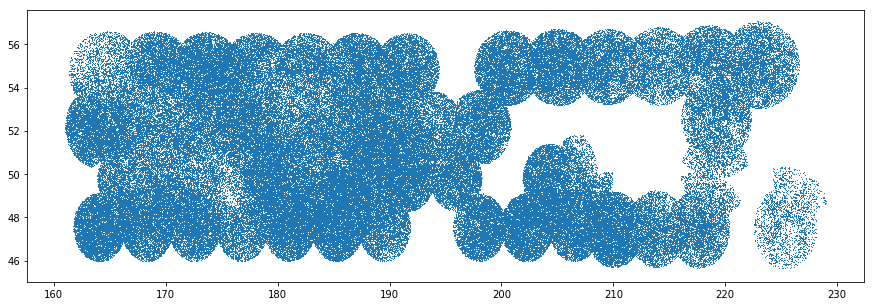

In [32]:
plt.rcParams["figure.figsize"] = (15,5)
plot(lofar_all["RA"],
     lofar_all["DEC"],
     ls="", marker=",");

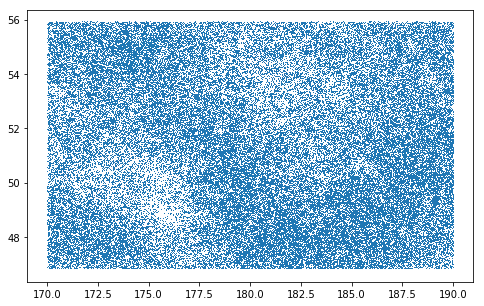

In [33]:
plt.rcParams["figure.figsize"] = (8,5)
plot(lofar["RA"],
     lofar["DEC"],
     ls="", marker=",");

In [34]:
len(lofar)

108381

### Summary of galaxy types in the combined catalogue

In [35]:
np.sum(combined_matched) # Matches

1339600

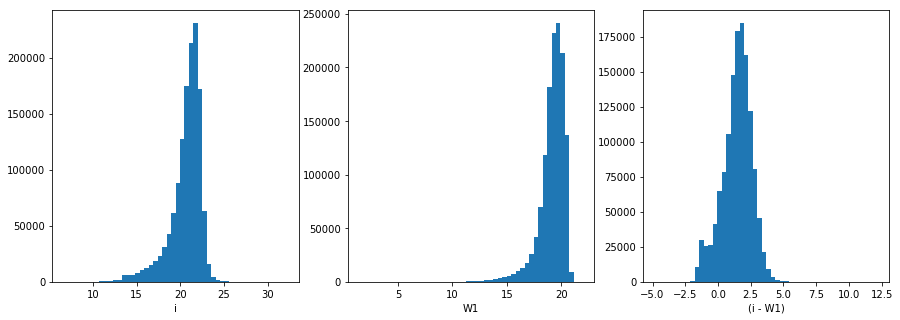

In [36]:
plt.rcParams["figure.figsize"] = (15,5)
subplot(1,3,1)
hist(combined["i"][combined_matched], bins=50)
xlabel("i")
subplot(1,3,2)
hist(combined["W1mag"][combined_matched], bins=50)
xlabel("W1")
subplot(1,3,3)
hist((combined["i"] - combined["W1mag"])[combined_matched], bins=50)
xlabel("(i - W1)");

In [37]:
np.sum(combined_panstarrs) # Only PanSTARSS

3071319

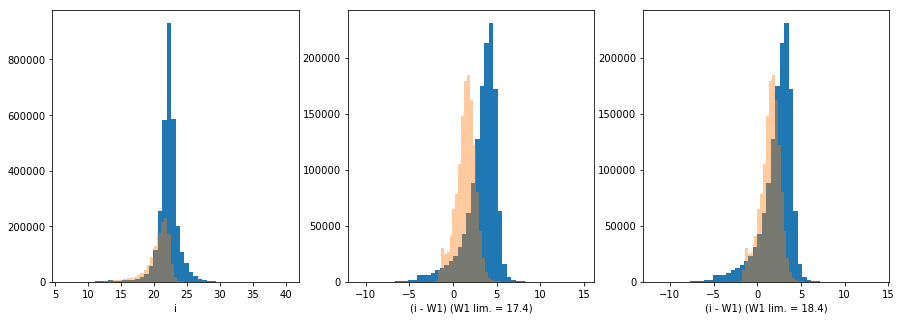

In [38]:
plt.rcParams["figure.figsize"] = (15,5)
subplot(1,3,1)
hist(combined["i"][combined_panstarrs], bins=50)
hist(combined["i"][combined_matched], bins=50, alpha=0.4)
xlabel("i")
subplot(1,3,2)
hist((combined["i"] - 17.4)[combined_matched], bins=50)
hist((combined["i"] - combined["W1mag"])[combined_matched], bins=50, alpha=0.4)
xlabel("(i - W1) (W1 lim. = 17.4)")
subplot(1,3,3)
hist((combined["i"] - 18.4)[combined_matched], bins=50)
hist((combined["i"] - combined["W1mag"])[combined_matched], bins=50, alpha=0.4)
xlabel("(i - W1) (W1 lim. = 18.4)");

In [39]:
np.sum(combined_wise) # Only WISE

821044

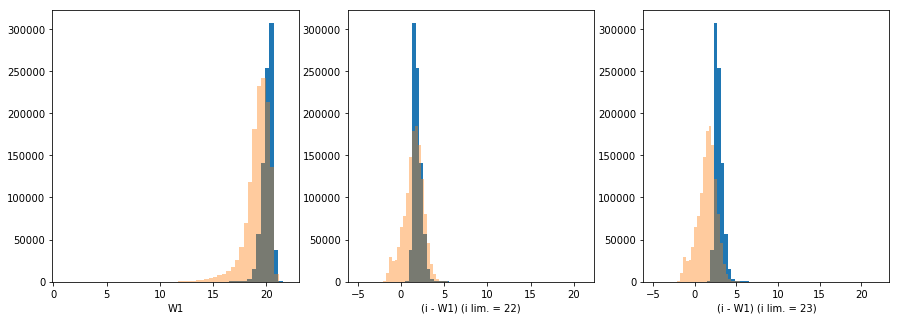

In [40]:
plt.rcParams["figure.figsize"] = (15,5)
subplot(1,3,1)
hist(combined["W1mag"][combined_wise], bins=50)
hist(combined["W1mag"][combined_matched], bins=50, alpha=0.4)
xlabel("W1")
subplot(1,3,2)
hist((22 - combined["W1mag"])[combined_wise], bins=50)
hist((combined["i"] - combined["W1mag"])[combined_matched], bins=50, alpha=0.4)
xlabel("(i - W1) (i lim. = 22)")
subplot(1,3,3)
hist((23 - combined["W1mag"])[combined_wise], bins=50)
hist((combined["i"] - combined["W1mag"])[combined_matched], bins=50, alpha=0.4)
xlabel("(i - W1) (i lim. = 23)");

In [41]:
np.sum(np.isnan(combined["i"]) & np.isnan(combined["W1mag"])) # Should not be here :)

2

In [42]:
combined_i = combined_matched | combined_panstarrs
combined_w1 = combined_matched | combined_wise
combined_only_i = combined_panstarrs & ~combined_matched
combined_only_w1 = combined_wise & ~combined_matched

## Maximum Likelihood 1st

### i-band preparation

In [43]:
catalogue_i = combined[combined_i]

In [44]:
bin_list_i = np.linspace(12., 30., 361) # Bins of 0.05

In [45]:
center_i = get_center(bin_list_i)

In [46]:
n_m_i = get_n_m(catalogue_i["i"], bin_list_i, field.area)

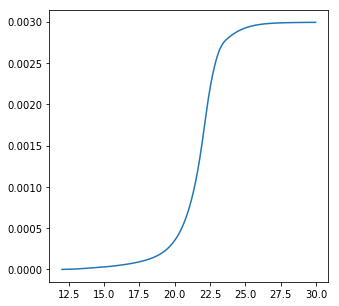

In [47]:
plt.rcParams["figure.figsize"] = (5,5)
plot(center_i, n_m_i);

In [48]:
q_m_i = estimate_q_m(catalogue_i["i"], bin_list_i, n_m_i, coords_lofar, coords_combined[combined_i], radius=5)

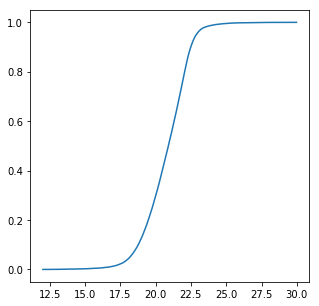

In [49]:
plt.rcParams["figure.figsize"] = (5,5)
plot(center_i, q_m_i);

### W1-band preparation

In [50]:
catalogue_w1 = combined[combined_w1]

In [51]:
bin_list_w1 = np.linspace(10., 23., 261) # Bins of 0.05

In [52]:
center_w1 = get_center(bin_list_w1)

In [53]:
n_m_w1 = get_n_m(catalogue_w1["W1mag"], bin_list_w1, field.area)

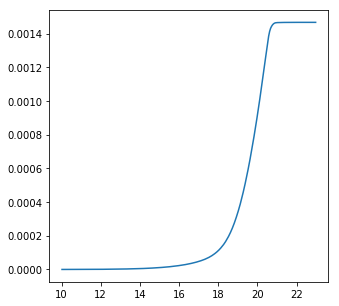

In [54]:
plt.rcParams["figure.figsize"] = (5,5)
plot(center_w1, n_m_w1);

In [55]:
q_m_w1 = estimate_q_m(catalogue_w1["W1mag"], 
                      bin_list_w1, 
                      n_m_w1, coords_lofar, 
                      coords_combined[combined_w1], 
                      radius=5)

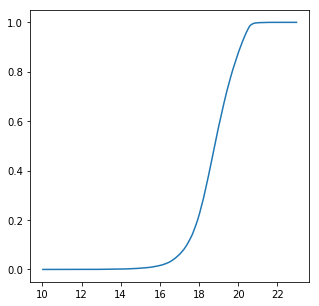

In [56]:
plot(center_w1, q_m_w1);

### $Q_0$ and likelihood estimators

In [57]:
# Old
Q0_i = 0.545
Q0_w1 = 0.77
# Better Q0
Q0_i = 0.503
Q0_w1 = 0.699
# Q0 for gaus catalogue
Q0_i = 0.46 # Q0_i at 5 arcsecs
Q0_w1 = 0.64 # Q0_w1 at 5 arcsecs

In [58]:
likelihood_ratio_i = SingleMLEstimator(Q0_i, n_m_i, q_m_i, center_i)

In [59]:
likelihood_ratio_w1 = SingleMLEstimator(Q0_w1, n_m_w1, q_m_w1, center_w1)

### i-band match

In [60]:
radius = 15

In [61]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[combined_i], radius*u.arcsec)

In [62]:
idx_lofar_unique = np.unique(idx_lofar)

In [63]:
lofar["lr_i"] = np.nan                   # Likelihood ratio
lofar["lr_dist_i"] = np.nan              # Distance to the selected source
lofar["lr_index_i"] = np.nan             # Index of the PanSTARRS source in combined

In [64]:
total_sources = len(idx_lofar_unique)
combined_aux_index = np.arange(len(combined))

In [65]:
def ml(i):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    i_mag = catalogue_i["i"][idx_0]
    lr_0 = likelihood_ratio_i(i_mag, d2d_0.arcsec, 1)
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[combined_i][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

In [66]:
res = parallel_process(idx_lofar_unique, ml)

100%|██████████| 94.8K/94.8K [20:56<00:00, 79.7it/s]
94753it [00:00, 294012.73it/s]


In [68]:
(lofar["lr_index_i"][idx_lofar_unique], 
 lofar["lr_dist_i"][idx_lofar_unique], 
 lofar["lr_i"][idx_lofar_unique]) = list(map(list, zip(*res)))

#### Threshold and selection for i-band

In [69]:
lofar["lr_i"][np.isnan(lofar["lr_i"])] = 0

In [70]:
threshold_i = np.percentile(lofar["lr_i"], 100*(1 - Q0_i))

In [71]:
threshold_i

0.61576312468503414

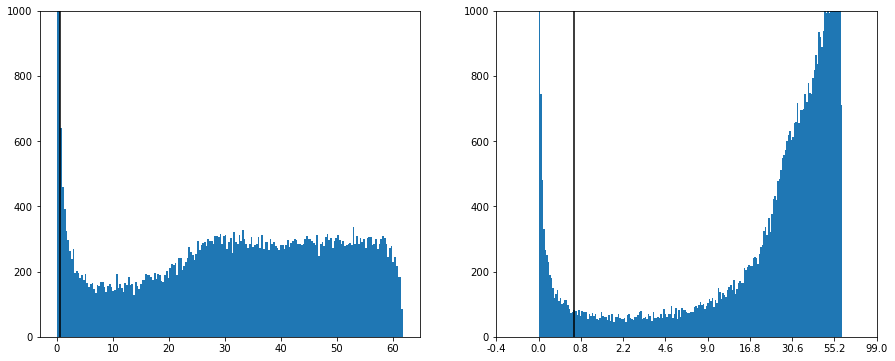

In [72]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lr_i"] != 0]["lr_i"], bins=200)
vlines([threshold_i], 0, 1000)
ylim([0,1000])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lr_i"] != 0]["lr_i"]+1), bins=200)
vlines(np.log10(threshold_i+1), 0, 1000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,1000]);

In [73]:
lofar["lr_index_sel_i"] = lofar["lr_index_i"]
lofar["lr_index_sel_i"][lofar["lr_i"] < threshold_i] = np.nan

### W1-band match

In [74]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[combined_w1], radius*u.arcsec)

In [75]:
idx_lofar_unique = np.unique(idx_lofar)

In [76]:
lofar["lr_w1"] = np.nan                   # Likelihood ratio
lofar["lr_dist_w1"] = np.nan              # Distance to the selected source
lofar["lr_index_w1"] = np.nan             # Index of the PanSTARRS source in combined

In [77]:
def ml_w1(i):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    w1_mag = catalogue_w1["W1mag"][idx_0]
    lr_0 = likelihood_ratio_w1(w1_mag, d2d_0.arcsec, 1)
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[combined_w1][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

In [78]:
res = parallel_process(idx_lofar_unique, ml_w1)

100%|██████████| 98.3K/98.3K [28:07<00:00, 58.2it/s]
98263it [00:00, 303693.96it/s]


In [79]:
(lofar["lr_index_w1"][idx_lofar_unique], 
 lofar["lr_dist_w1"][idx_lofar_unique], 
 lofar["lr_w1"][idx_lofar_unique]) = list(map(list, zip(*res)))

#### Threshold and selection for W1 band

In [80]:
lofar["lr_w1"][np.isnan(lofar["lr_w1"])] = 0

In [81]:
threshold_w1 = np.percentile(lofar["lr_w1"], 100*(1 - Q0_w1))

In [82]:
threshold_w1

0.0082166154749719906

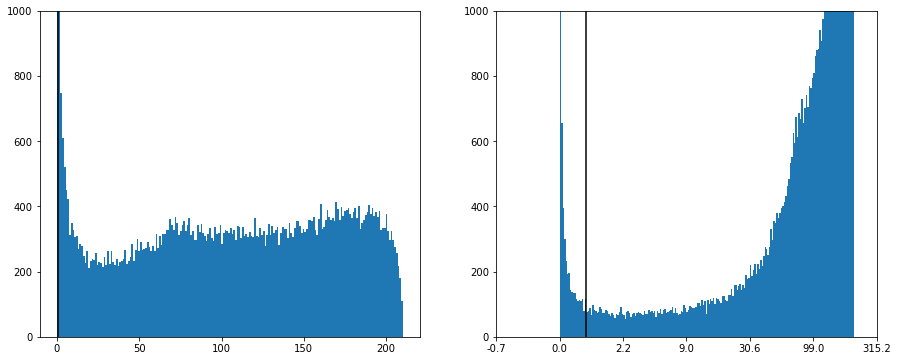

In [84]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lr_w1"] != 0]["lr_w1"], bins=200)
vlines([threshold_i], 0, 1000)
ylim([0,1000])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lr_w1"] != 0]["lr_w1"]+1), bins=200)
vlines(np.log10(threshold_i+1), 0, 1000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,1000]);

In [83]:
lofar["lr_index_sel_w1"] = lofar["lr_index_w1"]
lofar["lr_index_sel_w1"][lofar["lr_w1"] < threshold_w1] = np.nan

### Final selection of the match

We combine the ML matching done in i-band and W1-band. All the galaxies were the LR is above the selection ratio for the respective band are finally selected.

In [85]:
# lr_i_and_w1 = (lofar["lr_i"] != 0) & (lofar["lr_w1"] != 0)
# lr_only_i = (lofar["lr_i"] != 0) & (lofar["lr_w1"] == 0)
# lr_only_w1 = (lofar["lr_i"] == 0) & (lofar["lr_w1"] != 0)
# lr_no_match = (lofar["lr_i"] == 0) & (lofar["lr_w1"] == 0)
lr_i_and_w1 = ~np.isnan(lofar["lr_index_sel_i"]) & ~np.isnan(lofar["lr_index_sel_w1"])
lr_only_i = ~np.isnan(lofar["lr_index_sel_i"]) & np.isnan(lofar["lr_index_sel_w1"])
lr_only_w1 = np.isnan(lofar["lr_index_sel_i"]) & ~np.isnan(lofar["lr_index_sel_w1"])
lr_no_match = np.isnan(lofar["lr_index_sel_i"]) & np.isnan(lofar["lr_index_sel_w1"])

In [86]:
print(np.sum(lr_i_and_w1))
print(np.sum(lr_only_i))
print(np.sum(lr_only_w1))
print(np.sum(lr_no_match))

45683
4172
23681
34845


In [87]:
lofar["lr_index_1"] = np.nan
lofar["lr_dist_1"] = np.nan
lofar["lr_1"] = np.nan
lofar["lr_type_1"] = 0

In [88]:
# Only i matches
lofar["lr_1"][lr_only_i] = lofar["lr_i"][lr_only_i]
lofar["lr_index_1"][lr_only_i] = lofar["lr_index_i"][lr_only_i]
lofar["lr_dist_1"][lr_only_i] = lofar["lr_dist_i"][lr_only_i]
lofar["lr_type_1"][lr_only_i] = 1

# Only w1 matches
lofar["lr_1"][lr_only_w1] = lofar["lr_w1"][lr_only_w1]
lofar["lr_index_1"][lr_only_w1] = lofar["lr_index_w1"][lr_only_w1]
lofar["lr_dist_1"][lr_only_w1] = lofar["lr_dist_w1"][lr_only_w1]
lofar["lr_type_1"][lr_only_w1] = 2

# Both matches
lofar["lr_1"][lr_i_and_w1] = np.max([lofar["lr_i"][lr_i_and_w1], lofar["lr_w1"][lr_i_and_w1]], axis=0)
lofar["lr_type_1"][lr_i_and_w1] = np.argmax([lofar["lr_i"][lr_i_and_w1], lofar["lr_w1"][lr_i_and_w1]], axis=0) + 1

c1 = (lofar["lr_type_1"] == 1)
c2 = (lofar["lr_type_1"] == 2)
lofar["lr_index_1"][lr_i_and_w1 & c1] = lofar["lr_index_i"][lr_i_and_w1 & c1]
lofar["lr_index_1"][lr_i_and_w1 & c2] = lofar["lr_index_w1"][lr_i_and_w1 & c2]
lofar["lr_dist_1"][lr_i_and_w1 & c1] = lofar["lr_dist_i"][lr_i_and_w1 & c1]
lofar["lr_dist_1"][lr_i_and_w1 & c2] = lofar["lr_dist_w1"][lr_i_and_w1 & c2]

Summary of the number of sources matches of each type

In [90]:
print("match    sel-i: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1))
print("match   sel-W1: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match     both: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1) + 
                          np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match   i-only: ", np.sum(lofar["lr_type_1"] == 1) - np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1))
print("match  W1-only: ", np.sum(lofar["lr_type_1"] == 2) - np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match      all: ", np.sum(lofar["lr_type_1"] == 1) + 
                          np.sum(lofar["lr_type_1"] == 2))
print("         Total: ", len(lofar))

match    sel-i:  1455
match   sel-W1:  44228
match     both:  45683
match   i-only:  4172
match  W1-only:  23681
match      all:  73536
         Total:  108381


The number of sources for which the match in i-band and W1-band are above the threshold but gives a different match to the combined catalogue.

In [91]:
print(np.sum(lofar["lr_index_i"][lr_i_and_w1] != lofar["lr_index_w1"][lr_i_and_w1]))

5996


#### Duplicated sources

This is the nymber of sources of the combined catalogue that are combined to multiple LOFAR sources. In the case of the catalogue of Gaussians the number can be very high.

In [92]:
values, counts = np.unique(lofar[lofar["lr_type_1"] != 0]["lr_index_1"], return_counts=True)

In [93]:
len(values[counts > 1])

1912

In [94]:
n_dup, n_sour = np.unique(counts[counts > 1], return_counts=True)

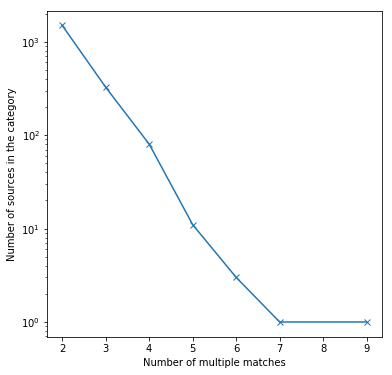

In [95]:
plt.rcParams["figure.figsize"] = (6,6)
semilogy(n_dup, n_sour, marker="x")
xlabel("Number of multiple matches")
ylabel("Number of sources in the category")

### Save intermediate data

In [97]:
if save_intermediate:
    pickle.dump([bin_list_i, center_i, Q0_i, n_m_i, q_m_i], 
                open("{}/lofar_params_1i.pckl".format(idp), 'wb'))
    pickle.dump([bin_list_w1, center_w1, Q0_w1, n_m_w1, q_m_w1], 
                open("{}/lofar_params_1w1.pckl".format(idp), 'wb'))
    lofar.write("{}/lofar_m1.fits".format(idp), format="fits")

## Second iteration using colour

From now on we will take into account the effect of the colour. The sample was distributed in several categories according to the colour of the source and this is considered here.

### Rusable parameters for all the iterations

These parameters are derived from the underlying population and will not change.

First we compute the number of galaxies in each bin for the combined catalogue

In [102]:
bin_list = [bin_list_w1 if i == 0 else bin_list_i for i in range(len(colour_bin_def))]
centers = [center_w1 if i == 0 else center_i for i in range(len(colour_bin_def))]

In [98]:
numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])

In [99]:
numbers_combined_bins

array([ 821044, 3071319,   84707,   60082,  103264,  149390,  107874,
        126702,  135867,  133622,  120776,  100308,   77175,   55963,
         58777,   18318,    6775])

Get the colour category and magnitudes for the matched LOFAR sources

In [100]:
n_m = []

# W1 only sources
n_m.append(get_n_m(combined["W1mag"][combined["category"] == 0], bin_list_w1, field.area))

# Rest of the sources
for i in range(1, len(colour_bin_def)):
    n_m.append(get_n_m(combined["i"][combined["category"] == i], bin_list_i, field.area))

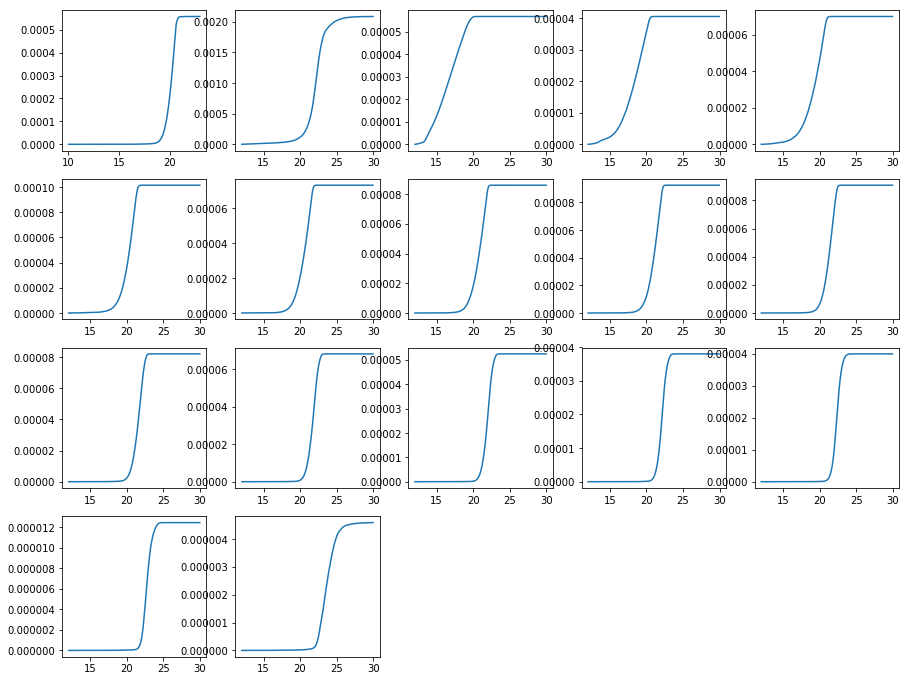

In [103]:
plt.rcParams["figure.figsize"] = (15,15)
for i, n_m_k in enumerate(n_m):
    subplot(5,5,i+1)
    plot(centers[i], n_m_k)

### Parameters of the matched sample

The parameters derived from the matched LOFAR galaxies: $q_0$, q(m) and the number of sources per category.

The columns "category", "W1mag" and "i" will contain the properties of the matched galaxies and will be updated in each iteration to save space.

In [104]:
lofar["category"] = np.nan
lofar["W1mag"] = np.nan
lofar["i"] = np.nan

In [105]:
c = ~np.isnan(lofar["lr_index_1"])
indices = lofar["lr_index_1"][c].astype(int)
lofar["category"][c] = combined[indices]["category"]
lofar["W1mag"][c] = combined[indices]["W1mag"]
lofar["i"][c] = combined[indices]["i"]

The next parameter represent the number of matched LOFAR sources in each colour category.

In [106]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) for c in range(len(numbers_combined_bins))])

In [107]:
numbers_lofar_combined_bins

array([21212,  5627,   214,   174,   628,  2377,  3220,  4853,  5554,
        5410,  4953,  4686,  4029,  3465,  4608,  1895,   631])

The $Q_0$ for each category are obtained by dividing the number of sources in the category by the total number of sources in the sample.

In [108]:
Q_0_colour = numbers_lofar_combined_bins/len(lofar) ### Q_0

In [109]:
q0_total = np.sum(Q_0_colour)

In [110]:
q0_total

0.67849530821823023

The q(m) is not estimated with the method of Fleuren et al. but with the most updated distributions and numbers for the matches.

In [111]:
q_m = []
radius = 15. 

# W1 only sources
q_m.append(get_q_m(lofar["W1mag"][lofar["category"] == 0], 
                   bin_list_w1, 
                   numbers_lofar_combined_bins[0], 
                   n_m[0], 
                   field.area, 
                   radius=radius))

# Rest of the sources
for i in range(1, len(numbers_lofar_combined_bins)):
    q_m.append(get_q_m(lofar["i"][lofar["category"] == i], 
                   bin_list_i, 
                   numbers_lofar_combined_bins[i], 
                   n_m[i], 
                   field.area, 
                   radius=radius))

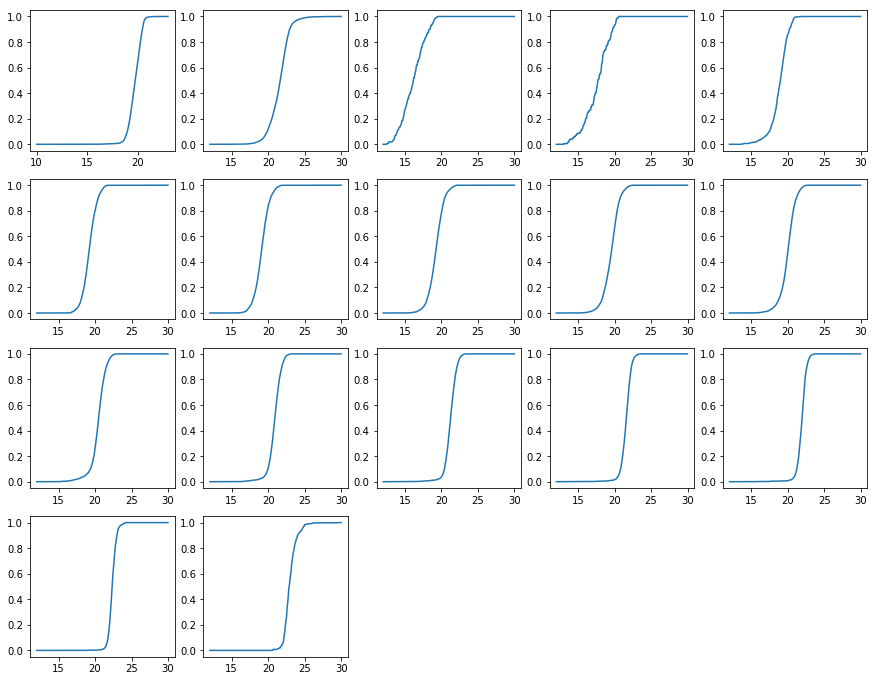

In [112]:
plt.rcParams["figure.figsize"] = (15,15)
for i, q_m_k in enumerate(q_m):
    subplot(5,5,i+1)
    plot(centers[i], q_m_k)

### Save intermediate parameters

In [113]:
if save_intermediate:
    pickle.dump([bin_list, centers, Q_0_colour, n_m, q_m], 
                open("{}/lofar_params_2.pckl".format(idp), 'wb'))

### Prepare for ML

In [114]:
selection = ~np.isnan(combined["category"]) # Avoid the two dreaded sources with no actual data
catalogue = combined[selection]

In [115]:
radius = 15

In [116]:
def apply_ml(i, likelihood_ratio_function):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    
    category = catalogue["category"][idx_0].astype(int)
    mag = catalogue["i"][idx_0]
    mag[category == 0] = catalogue["W1mag"][idx_0][category == 0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue["ra"][idx_0]
    c_dec = catalogue["dec"][idx_0]
    c_ra_err = catalogue["raErr"][idx_0]
    c_dec_err = catalogue["decErr"][idx_0]
    
    sigma = get_sigma(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)

    lr_0 = likelihood_ratio_function(mag, d2d_0.arcsec, sigma, category)
    
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[selection][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

### Run the cross-match

This will not need to be repeated after

In [117]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[selection], radius*u.arcsec)

In [118]:
idx_lofar_unique = np.unique(idx_lofar)

### Run the ML matching

In [119]:
likelihood_ratio = MultiMLEstimator(Q_0_colour, n_m, q_m, centers)

In [120]:
def ml(i):
    return apply_ml(i, likelihood_ratio)

In [121]:
res = parallel_process(idx_lofar_unique, ml, n_jobs=4)

100%|██████████| 104K/104K [36:24<00:00, 47.6it/s]
103904it [00:00, 290287.96it/s]


In [122]:
lofar["lr_index_2"] = np.nan
lofar["lr_dist_2"] = np.nan
lofar["lr_2"] = np.nan

In [123]:
(lofar["lr_index_2"][idx_lofar_unique], 
 lofar["lr_dist_2"][idx_lofar_unique], 
 lofar["lr_2"][idx_lofar_unique]) = list(map(list, zip(*res)))

Get the new threshold for the ML matching. FIX THIS

In [124]:
lofar["lr_2"][np.isnan(lofar["lr_2"])] = 0

In [126]:
threshold = np.percentile(lofar["lr_2"], 100*(1 - q0_total))
#manual_q0 = 0.65
#threshold = np.percentile(lofar["lr_2"], 100*(1 - manual_q0))

In [127]:
threshold

0.0087984286828943943

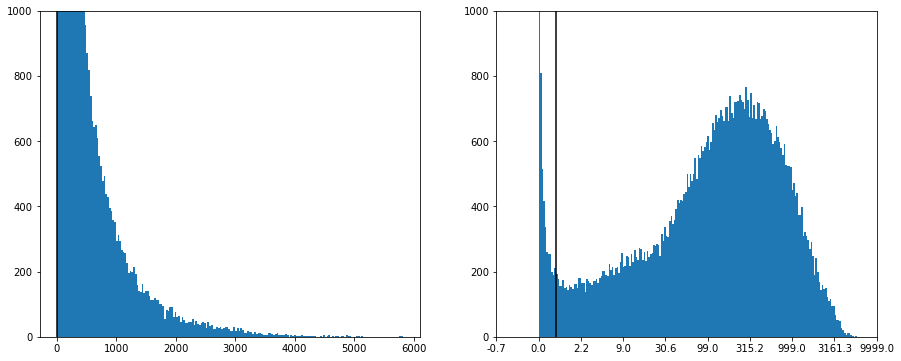

In [128]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lr_2"] != 0]["lr_2"], bins=200)
vlines([threshold_i], 0, 1000)
ylim([0,1000])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lr_2"] != 0]["lr_2"]+1), bins=200)
vlines(np.log10(threshold_i+1), 0, 1000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,1000]);

In [129]:
lofar["lr_index_sel_2"] = lofar["lr_index_2"]
lofar["lr_index_sel_2"][lofar["lr_2"] < threshold] = np.nan

In [130]:
n_changes = np.sum((lofar["lr_index_sel_2"] != lofar["lr_index_1"]) & 
                   ~np.isnan(lofar["lr_index_sel_2"]) &
                   ~np.isnan(lofar["lr_index_1"]))

In [131]:
n_changes

840

### Save intermediate data

In [134]:
if save_intermediate:
    lofar.write("{}/lofar_m2.fits".format(idp), format="fits")

## Save the combined data

In [ ]:
combined["lr_index_sel_2"] = np.arange(len(combined)).astype(float)

In [ ]:
combined["i"].fill_value = 1e+20
combined["W1mag"].fill_value = 1e+20
combined["colour"].fill_value = 1e+20
combined["category"].fill_value = 999999

In [ ]:
lofar.remove_column("i")
lofar.remove_column("category")
lofar.remove_column("W1mag")

In [ ]:
lofar_combined = join(lofar, combined, join_type='left', keys='lr_index_sel_2')

In [ ]:
for col in lofar_combined.colnames:
    try:
        print(col, lofar_combined[col].fill_value)
    except AttributeError:
        print(col, "NO_FILL")

In [ ]:
lofar_combined.write("lofar_matched_gaus.fits", format="fits")